In [21]:
import os
import pandas as pd
import pandas_dq as pdq
import dataframe_image as dfi
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# CARICAMENTO DEL DATASET

In [14]:
path = os.path.join(os.getcwd(), "wine_quality", "winequality-white.csv")

df = pd.read_csv(path, sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


## Rappresentazione grafica del dataset

Ogni grafico mostra la distribuzione dei valori di ogni colonna del dataset

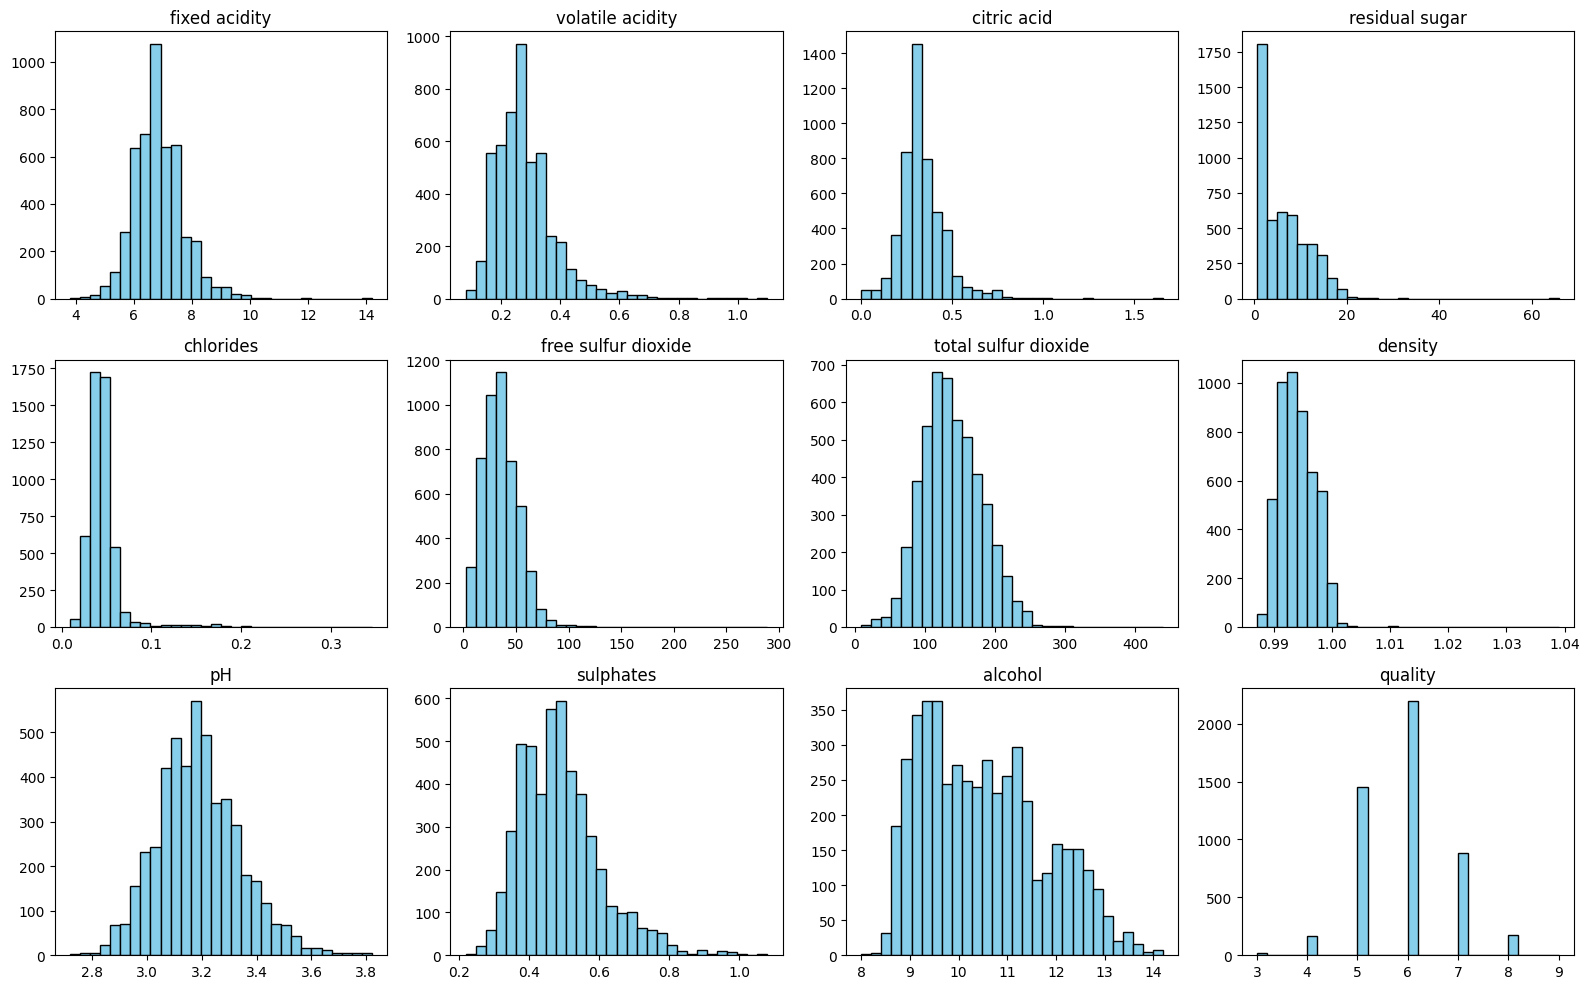

In [15]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(3, 4, i)
    plt.hist(df[col], bins=30, color='skyblue', edgecolor="black")
    plt.title(col)
    plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "data_distribution.png"))
plt.show()

## ANALISI ESPLORATIVA

Andiamo adesso ad analizzare il dataset, utilizzando sia funzioni scritte ad hoc che la libreria pandas_dq.
Ci verrà fatto un report sul dataset che evidenzierà i problemi del nostro dataset, come gli outliers e le features superflue dovute ad un'alta correlazione tra colonne

In [ ]:
print(f"Dimensioni del dataset: {df.shape[0]} campioni, {df.shape[1]} features")

dqr = pdq.dq_report(df, target='quality', verbose=1)

# Esportiamo il report per l'inserimento in tesi
dqr.dfi.export(os.path.join(os.getcwd(), "immagini_progetto", "data_quality_report.png"))

Dimensioni del dataset: 4898 campioni, 12 features
There are 937 duplicate rows in your dataset
    Alert: Dropping duplicate rows can sometimes cause your column data types to change to object!
    All variables classified into correct types.


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
fixed acidity,float64,0.000000,NA,3.800000,14.200000,Column has 106 outliers greater than upper bound (8.80) or lower than lower bound(4.80). Cap them or remove them.
volatile acidity,float64,0.000000,NA,0.080000,1.100000,Column has 133 outliers greater than upper bound (0.51) or lower than lower bound(0.03). Cap them or remove them.
citric acid,float64,0.000000,NA,0.000000,1.660000,Column has 223 outliers greater than upper bound (0.57) or lower than lower bound(0.09). Cap them or remove them.
residual sugar,float64,0.000000,NA,0.600000,65.800000,Column has 16 outliers greater than upper bound (19.85) or lower than lower bound(-9.35). Cap them or remove them.
chlorides,float64,0.000000,NA,0.009000,0.346000,Column has 178 outliers greater than upper bound (0.07) or lower than lower bound(0.01). Cap them or remove them.
free sulfur dioxide,float64,0.000000,NA,2.000000,289.000000,Column has 44 outliers greater than upper bound (78.00) or lower than lower bound(-10.00). Cap them or remove them.
total sulfur dioxide,float64,0.000000,NA,9.000000,440.000000,Column has 14 outliers greater than upper bound (256.00) or lower than lower bound(16.00). Cap them or remove them.
density,float64,0.000000,NA,0.987110,1.038980,"Column has 6 outliers greater than upper bound (1.00) or lower than lower bound(0.99). Cap them or remove them., Column has a high correlation with ['residual sugar']. Consider dropping one of them."
pH,float64,0.000000,NA,2.720000,3.820000,Column has 46 outliers greater than upper bound (3.59) or lower than lower bound(2.79). Cap them or remove them.
sulphates,float64,0.000000,NA,0.220000,1.080000,Column has 96 outliers greater than upper bound (0.76) or lower than lower bound(0.20). Cap them or remove them.
